In [1]:
import yaml
from easydict import EasyDict as edict
from alphapose.utils import Registry
import inspect
from torch import nn
import torch
import cv2
import matplotlib.pyplot as plt
from alphapose.models import builder
import numpy as np
import os

# Pose Model

In [2]:
with open("configs/halpe_26/resnet/256x192_res50_lr1e-3_1x.yaml") as f:
    pose_model_config = edict(yaml.load(f, Loader=yaml.FullLoader))

In [3]:
def build_from_cfg(cfg, registry, default_args=None):
    """Build a module from config dict.

    Args:
        cfg (dict): Config dict. It should at least contain the key "type".
        registry (:obj:`Registry`): The registry to search the type from.
        default_args (dict, optional): Default initialization arguments.

    Returns:
        obj: The constructed object.
    """
    assert isinstance(cfg, dict) and 'TYPE' in cfg
    assert isinstance(default_args, dict) or default_args is None
    args = cfg.copy()
    obj_type = args.pop('TYPE')

    if isinstance(obj_type, str):
        obj_cls = registry.get(obj_type)
        if obj_cls is None:
            raise KeyError('{} is not in the {} registry'.format(
                obj_type, registry.name))
    elif inspect.isclass(obj_type):
        obj_cls = obj_type
    else:
        raise TypeError('type must be a str or valid type, but got {}'.format(
            type(obj_type)))
    if default_args is not None:
        for name, value in default_args.items():
            args.setdefault(name, value)
    return obj_cls(**args)

In [4]:
def build(cfg, registry, default_args=None):
    if isinstance(cfg, list):
        modules = [
            build_from_cfg(cfg_, registry, default_args) for cfg_ in cfg
        ]
        return nn.Sequential(*modules)
    else:
        return build_from_cfg(cfg, registry, default_args)

In [5]:
from alphapose.models.fastpose import FastPose
SPPE = Registry("sppe")
SPPE.register_module(FastPose)

checkpoint = "pretrained_models/halpe26_fast_res50_256x192.pth"
device = "mps"

default_args = {
    'PRESET': pose_model_config.DATA_PRESET,
}
pose_model = build(pose_model_config.MODEL, SPPE, default_args=default_args)
pose_model.load_state_dict(torch.load(checkpoint, map_location=device))
pose_model.to(device=device)
pose_model.eval()

/Users/uinone/.local/share/virtualenvs/AlphaPose-HZ1PtCuD/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/uinone/.local/share/virtualenvs/AlphaPose-HZ1PtCuD/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FastPose(
  (preact): SEResnet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (se): SELayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)

# Detection Model

In [6]:
from detector.apis import get_detector
from alphapose.utils.transforms import get_func_heatmap_to_coord
from alphapose.utils.presets import SimpleTransform, SimpleTransform3DSMPL
from alphapose.utils.pPose_nms import pose_nms

In [7]:
class DetectionLoader():
    def __init__(self, detector, cfg, opt):
        self.cfg = cfg
        self.opt = opt
        self.device = opt.device
        self.detector = detector

        self._input_size = cfg.DATA_PRESET.IMAGE_SIZE
        self._output_size = cfg.DATA_PRESET.HEATMAP_SIZE

        self._sigma = cfg.DATA_PRESET.SIGMA

        if cfg.DATA_PRESET.TYPE == 'simple':
            pose_dataset = builder.retrieve_dataset(self.cfg.DATASET.TRAIN)
            self.transformation = SimpleTransform(
                pose_dataset, scale_factor=0,
                input_size=self._input_size,
                output_size=self._output_size,
                rot=0, sigma=self._sigma,
                train=False, add_dpg=False, gpu_device=self.device)
        elif cfg.DATA_PRESET.TYPE == 'simple_smpl':
            # TODO: new features
            from easydict import EasyDict as edict
            dummpy_set = edict({
                'joint_pairs_17': None,
                'joint_pairs_24': None,
                'joint_pairs_29': None,
                'bbox_3d_shape': (2.2, 2.2, 2.2)
            })
            self.transformation = SimpleTransform3DSMPL(
                dummpy_set, scale_factor=cfg.DATASET.SCALE_FACTOR,
                color_factor=cfg.DATASET.COLOR_FACTOR,
                occlusion=cfg.DATASET.OCCLUSION,
                input_size=cfg.MODEL.IMAGE_SIZE,
                output_size=cfg.MODEL.HEATMAP_SIZE,
                depth_dim=cfg.MODEL.EXTRA.DEPTH_DIM,
                bbox_3d_shape=(2.2, 2,2, 2.2),
                rot=cfg.DATASET.ROT_FACTOR, sigma=cfg.MODEL.EXTRA.SIGMA,
                train=False, add_dpg=False, gpu_device=self.device,
                loss_type=cfg.LOSS['TYPE'])

        self.image = (None, None, None, None)
        self.det = (None, None, None, None, None, None, None)
        self.pose = (None, None, None, None, None, None, None)
    
    def process(self, image):
        # start to pre process images for object detection
        self.image_preprocess(image)
        # start to detect human in images
        self.image_detection()
        # start to post process cropped human image for pose estimation
        self.image_postprocess()
        return self

    def image_preprocess(self, image):
        # expected image shape like (1,3,h,w) or (3,h,w)
        img = self.detector.image_preprocess(image)
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img)
        # add one dimension at the front for batch if image shape (3,h,w)
        if img.dim() == 3:
            img = img.unsqueeze(0)
        orig_img = image # scipy.misc.imread(im_name_k, mode='RGB') is depreciated
        im_dim = orig_img.shape[1], orig_img.shape[0]

        with torch.no_grad():
            im_dim = torch.FloatTensor(im_dim).repeat(1, 2)

        self.image = (img, orig_img, im_dim)

    def image_detection(self):
        imgs, orig_imgs, im_dim_list = self.image
        if imgs is None:
            self.det = (None, None, None, None, None, None, None)
            return

        with torch.no_grad():
            dets = self.detector.images_detection(imgs, im_dim_list)
            if isinstance(dets, int) or dets.shape[0] == 0:
                self.det = (orig_imgs, None, None, None, None, None)
                return
            if isinstance(dets, np.ndarray):
                dets = torch.from_numpy(dets)
            dets = dets.cpu()
            boxes = dets[:, 1:5]
            scores = dets[:, 5:6]
            ids = torch.zeros(scores.shape)

        boxes = boxes[dets[:, 0] == 0]
        if isinstance(boxes, int) or boxes.shape[0] == 0:
            self.det = (orig_imgs, None, None, None, None, None)
            return
        inps = torch.zeros(boxes.size(0), 3, *self._input_size)
        cropped_boxes = torch.zeros(boxes.size(0), 4)

        self.det = (orig_imgs, boxes, scores[dets[:, 0] == 0], ids[dets[:, 0] == 0], inps, cropped_boxes)

    def image_postprocess(self):
        with torch.no_grad():
            (orig_img, boxes, scores, ids, inps, cropped_boxes) = self.det
            if orig_img is None:
                self.pose = (None, None, None, None, None, None, None)
                return
            if boxes is None or boxes.nelement() == 0:
                self.pose = (None, orig_img, boxes, scores, ids, None)
                return

            for i, box in enumerate(boxes):
                inps[i], cropped_box = self.transformation.test_transform(orig_img, box)
                cropped_boxes[i] = torch.FloatTensor(cropped_box)

            self.pose = (inps, orig_img, boxes, scores, ids, cropped_boxes)

    def read(self):
        return self.pose

In [8]:
class DataWriter():
    def __init__(self, cfg, opt):
        self.cfg = cfg
        self.opt = opt

        self.eval_joints = list(range(cfg.DATA_PRESET.NUM_JOINTS))
        self.heatmap_to_coord = get_func_heatmap_to_coord(cfg)
        self.item = (None, None, None, None, None, None, None)
        
        loss_type = self.cfg.DATA_PRESET.get('LOSS_TYPE', 'MSELoss')
        num_joints = self.cfg.DATA_PRESET.NUM_JOINTS
        if loss_type == 'MSELoss':
            self.vis_thres = [0.4] * num_joints
        elif 'JointRegression' in loss_type:
            self.vis_thres = [0.05] * num_joints
        elif loss_type == 'Combined':
            if num_joints == 68:
                hand_face_num = 42
            else:
                hand_face_num = 110
            self.vis_thres = [0.4] * (num_joints - hand_face_num) + [0.05] * hand_face_num

        self.use_heatmap_loss = (self.cfg.DATA_PRESET.get('LOSS_TYPE', 'MSELoss') == 'MSELoss')

    def start(self):
        # start to read pose estimation results
        return self.update()

    def update(self):
        norm_type = self.cfg.LOSS.get('NORM_TYPE', None)
        hm_size = self.cfg.DATA_PRESET.HEATMAP_SIZE

        # get item
        (boxes, scores, ids, hm_data, cropped_boxes, orig_img) = self.item
        if orig_img is None:
            return None
        # image channel RGB->BGR
        orig_img = np.array(orig_img, dtype=np.uint8)[:, :, ::-1]
        self.orig_img = orig_img
        if boxes is None or len(boxes) == 0:
            return None
        else:
            # location prediction (n, kp, 2) | score prediction (n, kp, 1)
            assert hm_data.dim() == 4
            if hm_data.size()[1] == 136:
                self.eval_joints = [*range(0,136)]
            elif hm_data.size()[1] == 26:
                self.eval_joints = [*range(0,26)]
            elif hm_data.size()[1] == 133:
                self.eval_joints = [*range(0,133)]
            pose_coords = []
            pose_scores = []

            for i in range(hm_data.shape[0]):
                bbox = cropped_boxes[i].tolist() 
                if isinstance(self.heatmap_to_coord, list):
                    pose_coords_body_foot, pose_scores_body_foot = self.heatmap_to_coord[0](
                        hm_data[i][self.eval_joints[:-110]], bbox, hm_shape=hm_size, norm_type=norm_type)
                    pose_coords_face_hand, pose_scores_face_hand = self.heatmap_to_coord[1](
                        hm_data[i][self.eval_joints[-110:]], bbox, hm_shape=hm_size, norm_type=norm_type)
                    pose_coord = np.concatenate((pose_coords_body_foot, pose_coords_face_hand), axis=0)
                    pose_score = np.concatenate((pose_scores_body_foot, pose_scores_face_hand), axis=0)
                else:
                    pose_coord, pose_score = self.heatmap_to_coord(hm_data[i][self.eval_joints], bbox, hm_shape=hm_size, norm_type=norm_type)
                pose_coords.append(torch.from_numpy(pose_coord).unsqueeze(0))
                pose_scores.append(torch.from_numpy(pose_score).unsqueeze(0))
            preds_img = torch.cat(pose_coords)
            preds_scores = torch.cat(pose_scores)

            boxes, scores, ids, preds_img, preds_scores, pick_ids = \
                pose_nms(boxes, scores, ids, preds_img, preds_scores, self.opt.min_box_area, use_heatmap_loss=self.use_heatmap_loss)

            _result = []
            for k in range(len(scores)):
                _result.append(
                    {
                        'keypoints':preds_img[k],
                        'kp_score':preds_scores[k],
                        'proposal_score': torch.mean(preds_scores[k]) + scores[k] + 1.25 * max(preds_scores[k]),
                        'idx':ids[k],
                        'bbox':[boxes[k][0], boxes[k][1], boxes[k][2]-boxes[k][0],boxes[k][3]-boxes[k][1]] 
                    }
                )

            result = {
                'result': _result
            }

            # if hm_data.size()[1] == 49:
            #     from alphapose.utils.vis import vis_frame_dense as vis_frame
            # elif self.opt.vis_fast:
            #     from alphapose.utils.vis import vis_frame_fast as vis_frame
            # else:
            #     from alphapose.utils.vis import vis_frame
            # self.vis_frame = vis_frame

        return result

    def save(self, boxes, scores, ids, hm_data, cropped_boxes, orig_img):
        self.item = (boxes, scores, ids, hm_data, cropped_boxes, orig_img)

In [9]:
class dummy_obj:
    def __init__(self, model_name="yolo"):
        self.detector = model_name
        self.device = "mps"
        self.gpus = [-1]
        self.min_box_area = 0
        self.vis_fast = False

detection_model = DetectionLoader(get_detector(dummy_obj()), pose_model_config, dummy_obj())

# DataWriter

In [10]:
writer = DataWriter(pose_model_config, dummy_obj())

# Reference

In [81]:
img = cv2.imread("examples/demo/custom_example_2.png")[...,::-1]

img_h, img_w = img.shape[:2]

with torch.no_grad():
    # inps, orig_img, boxes, scores, ids, cropped_boxes
    outp = detection_model.process(img).read()

(inps, orig_img, boxes, scores, ids, cropped_boxes) = outp

cropped_objs = []

for bbox, score, obj_id in zip(cropped_boxes, scores, ids):
    if score < 0.8 or obj_id != 0:
        print(score)
        continue
    l,t,r,b = np.array(bbox, np.int32)
    l = max(l, 0)
    t = max(t, 0)
    r = min(r, img_w-1)
    b = min(b, img_h-1)

    # cv2.rectangle(img, (l,t), (r,b), (255,0,0), 1)
    cropped_objs.append(img[t:b, l:r])

# plt.imshow(img)

tensor([0.1267])


In [82]:
# import json
# with open("examples/demo/test.json", "r") as f:
#     data = json.loads(f.readline())
# inps = torch.FloatTensor(data["inps"])
# inps = torch.unsqueeze(inps, dim=0)

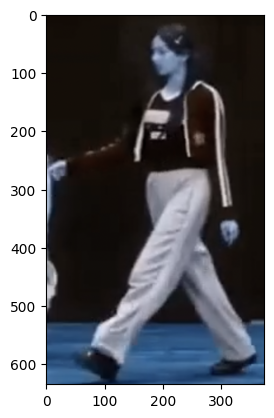

In [83]:
plt.imshow(cropped_objs[0])

In [84]:
with torch.no_grad():
    hm = pose_model(inps.to("mps"))

In [85]:
hm = hm.cpu()

In [86]:
# data['id']

In [87]:
# boxes = torch.FloatTensor(data['box'])
# scores = torch.FloatTensor(data['scores'])
# ids = torch.FloatTensor([0.])
# cropped_boxes = torch.FloatTensor(data['crooped_box'])
# orig_img = img
writer.save(boxes, scores, ids, hm, cropped_boxes, orig_img)

In [88]:
hp_outp = writer.start()

In [89]:
hp_outp["result"][0]

{'keypoints': tensor([[184.1346,  74.3785],
         [195.5031,  62.9707],
         [184.8625,  62.9704],
         [233.3058,  69.0115],
         [225.2921,  68.8057],
         [267.6477, 138.9628],
         [183.6548, 148.2022],
         [287.6371, 240.5235],
         [144.8285, 234.1137],
         [305.6003, 332.3301],
         [ 53.6578, 260.6694],
         [247.2929, 301.6743],
         [194.8070, 305.5742],
         [180.6721, 441.9246],
         [258.8312, 443.3295],
         [106.9237, 573.7204],
         [329.2916, 571.6895],
         [213.6973,  30.9914],
         [223.9353, 114.7032],
         [219.1191, 294.8610],
         [ 63.7975, 584.9498],
         [287.0630, 610.3754],
         [ 75.2799, 590.4214],
         [289.1326, 601.7919],
         [115.5265, 604.9506],
         [350.6898, 585.7888]]),
 'kp_score': tensor([[0.9357],
         [0.9487],
         [0.9531],
         [0.9177],
         [0.6536],
         [0.8912],
         [0.9328],
         [0.8876],
         [0.905

# Visualize

In [90]:
import math

RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
CYAN = (255, 255, 0)
YELLOW = (0, 255, 255)
ORANGE = (0, 165, 255)
PURPLE = (255, 0, 255)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
DEFAULT_FONT = cv2.FONT_HERSHEY_SIMPLEX

l_pair = [
    (0, 1), (0, 2), (1, 3), (2, 4),  # Head
    (5, 18), (6, 18), (5, 7), (7, 9), (6, 8), (8, 10),# Body
    (17, 18), (18, 19), (19, 11), (19, 12),
    (11, 13), (12, 14), (13, 15), (14, 16),
    (20, 24), (21, 25), (23, 25), (22, 24), (15, 24), (16, 25),# Foot
]
p_color = [(0, 255, 255), (0, 191, 255), (0, 255, 102), (0, 77, 255), (0, 255, 0),  # Nose, LEye, REye, LEar, REar
            (77, 255, 255), (77, 255, 204), (77, 204, 255), (191, 255, 77), (77, 191, 255), (191, 255, 77),  # LShoulder, RShoulder, LElbow, RElbow, LWrist, RWrist
            (204, 77, 255), (77, 255, 204), (191, 77, 255), (77, 255, 191), (127, 77, 255), (77, 255, 127),  # LHip, RHip, LKnee, Rknee, LAnkle, RAnkle, Neck
            (77, 255, 255), (0, 255, 255), (77, 204, 255),  # head, neck, shoulder
            (0, 255, 255), (0, 191, 255), (0, 255, 102), (0, 77, 255), (0, 255, 0), (77, 255, 255)] # foot

line_color = [(0, 215, 255), (0, 255, 204), (0, 134, 255), (0, 255, 50),
                (0, 255, 102), (77, 255, 222), (77, 196, 255), (77, 135, 255), (191, 255, 77), (77, 255, 77),
                (77, 191, 255), (204, 77, 255), (77, 222, 255), (255, 156, 127),
                (0, 127, 255), (255, 127, 77), (0, 77, 255), (255, 77, 36), 
                (0, 77, 255), (0, 77, 255), (0, 77, 255), (0, 77, 255), (255, 156, 127), (255, 156, 127)]



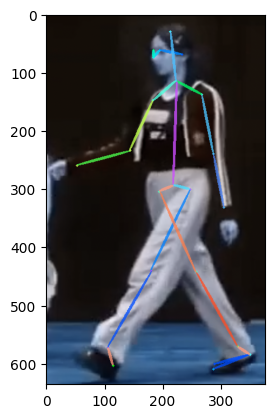

In [91]:
for human in hp_outp['result']:
    part_line = {}
    kp_preds = human['keypoints']
    kp_scores = human['kp_score']

    color = BLUE

    # Draw keypoints
    for n in range(kp_scores.shape[0]):
        if kp_scores[n] <= 0.8:
            continue
        cor_x, cor_y = int(kp_preds[n, 0]), int(kp_preds[n, 1])
        part_line[n] = (int(cor_x), int(cor_y))
        bg = img.copy()
        if n < len(p_color):
            cv2.circle(bg, (int(cor_x), int(cor_y)), 2, p_color[n], -1)
        else:
            cv2.circle(bg, (int(cor_x), int(cor_y)), 1, (255,255,255), 2)
        
        # Now create a mask of logo and create its inverse mask also
        if n < len(p_color):
            transparency = float(max(0, min(1, kp_scores[n])))
        else:
            transparency = float(max(0, min(1, kp_scores[n]*2)))
        img = cv2.addWeighted(bg, transparency, img, 1 - transparency, 0)

    # Draw limbs
    for i, (start_p, end_p) in enumerate(l_pair):
        if start_p in part_line and end_p in part_line:
            start_xy = part_line[start_p]
            end_xy = part_line[end_p]
            bg = img.copy()

            X = (start_xy[0], end_xy[0])
            Y = (start_xy[1], end_xy[1])
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((Y[0] - Y[1]) ** 2 + (X[0] - X[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(Y[0] - Y[1], X[0] - X[1]))
            stickwidth = (kp_scores[start_p] + kp_scores[end_p]) + 1
            polygon = cv2.ellipse2Poly((int(mX), int(mY)), (int(length/2), int(stickwidth)), int(angle), 0, 360, 1)
            if i < len(line_color):
                cv2.fillConvexPoly(bg, polygon, line_color[i])
            else:
                cv2.line(bg, start_xy, end_xy, (255,255,255), 1)
            if n < len(p_color):
                transparency = float(max(0, min(1, 0.5 * (kp_scores[start_p] + kp_scores[end_p])-0.1)))
            else:
                transparency = float(max(0, min(1, (kp_scores[start_p] + kp_scores[end_p]))))

            #transparency = float(max(0, min(1, 0.5 * (kp_scores[start_p] + kp_scores[end_p])-0.1)))
            img = cv2.addWeighted(bg, transparency, img, 1 - transparency, 0)

plt.imshow(img)

# 3D Pose estimation

In [92]:
import sys
from os import path

sys.path.append(path.abspath("./MotionBERT/"))

from collections import OrderedDict
from MotionBERT.lib.utils.learning import load_backbone

In [93]:
with open("MotionBERT/configs/pose3d/MB_ft_h36m.yaml") as f:
    pose3d_model_config = edict(yaml.load(f, Loader=yaml.FullLoader))

In [94]:
class DummyObj3D:
    def __init__(self, config_dict):
        self.backbone = "DSTformer"
        self.maxlen = config_dict["maxlen"]
        self.dim_feat = config_dict["dim_feat"]
        self.mlp_ratio = config_dict["mlp_ratio"]
        self.depth = config_dict["depth"]
        self.dim_rep = config_dict["dim_rep"]
        self.num_heads = config_dict["num_heads"]
        self.att_fuse = config_dict["att_fuse"]
        self.num_joints = config_dict["num_joints"]

In [95]:
pose3d_args = DummyObj3D(pose3d_model_config)

In [96]:
checkpoint_ = torch.load("MotionBERT/weights/MB_ft_h36m.bin", map_location=lambda storage, loc: storage)

checkpoint = OrderedDict()

for k in checkpoint_['model_pos'].keys():
    new_key = ".".join(k.split(".")[1:])
    checkpoint[new_key] = checkpoint_['model_pos'][k]

In [38]:
pose3d_model = load_backbone(pose3d_args)
pose3d_model.load_state_dict(checkpoint, strict=True)
pose3d_model.to("mps")
pose3d_model.eval()

DSTformer(
  (joints_embed): Linear(in_features=3, out_features=512, bias=True)
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks_st): ModuleList(
    (0-4): 5 x Block(
      (norm1_s): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (norm1_t): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn_s): Attention(
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (attn_t): Attention(
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2_s): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (norm2_t): LayerNorm((512,),

In [97]:
keypoints = torch.concat([hp_outp["result"][0]['keypoints'], hp_outp["result"][0]['kp_score']], dim=-1)
keypoints = torch.unsqueeze(keypoints, dim=0)
keypoints.shape

torch.Size([1, 26, 3])

In [40]:
from MotionBERT.lib.data.dataset_wild import WildDetDataset

In [98]:
wild_dataset = WildDetDataset(
    clip_len=1,
    image_size=img.shape[:2][::-1],
)

In [99]:
wild_dataset.add_data(keypoints)

In [100]:
wild_dataset[0]

[array([[[ 0.16552718, -0.12307999,  0.9084718 ],
         [ 0.03620732, -0.06609474,  0.89110136],
         [ 0.3767616 ,  0.6666464 ,  0.84194404],
         [ 0.75155085,  1.349412  ,  0.9086131 ],
         [ 0.31538796, -0.08683858,  0.88637507],
         [-0.03897793,  0.65917355,  0.8520611 ],
         [-0.43125695,  1.3602148 ,  0.8870617 ],
         [ 0.1783362 , -0.60222304,  0.90277827],
         [ 0.19114523, -1.0813661 ,  0.89708465],
         [-0.02056049, -1.2958591 ,  0.93566895],
         [ 0.1366879 , -1.5266414 ,  0.9363475 ],
         [ 0.423658  , -0.9523253 ,  0.891245  ],
         [ 0.52998483, -0.41210896,  0.8875532 ],
         [ 0.6255332 ,  0.07622414,  0.81696767],
         [-0.02311252, -0.9031796 ,  0.93275356],
         [-0.22963569, -0.44620383,  0.9057288 ],
         [-0.714586  , -0.30494982,  0.85761315]]], dtype=float32)]

In [101]:
test_2d_kp = torch.FloatTensor(wild_dataset[0][0])
test_2d_kp = torch.unsqueeze(test_2d_kp, dim=0)

with torch.no_grad():
    outp_3d = pose3d_model(test_2d_kp.to("mps")).cpu()

In [102]:
outp_3d.shape

torch.Size([1, 1, 17, 3])

In [46]:
from MotionBERT.lib.utils.vismo import pixel2world_vis_motion

In [104]:
motion = np.transpose(outp_3d[0], (1,2,0))   #(T,17,D) -> (17,D,T) 

motion_world = pixel2world_vis_motion(motion, dim=3)
np.array(motion_world, np.int32)

array([[[256],
        [256],
        [  0]],

       [[218],
        [265],
        [  2]],

       [[309],
        [463],
        [ 24]],

       [[368],
        [541],
        [ 33]],

       [[296],
        [262],
        [ -7]],

       [[200],
        [459],
        [ 26]],

       [[151],
        [538],
        [ 37]],

       [[257],
        [135],
        [-21]],

       [[260],
        [ 23],
        [-47]],

       [[210],
        [-13],
        [-54]],

       [[249],
        [-29],
        [-53]],

       [[317],
        [ 45],
        [-49]],

       [[347],
        [182],
        [-17]],

       [[375],
        [304],
        [ -5]],

       [[204],
        [ 56],
        [-29]],

       [[152],
        [171],
        [ -8]],

       [[ 34],
        [205],
        [-17]]], dtype=int32)

tensor([[256.4081, 256.4396,  -0.5419],
        [218.8935, 265.5174,   2.6439],
        [309.2737, 463.0358,  24.1704],
        [368.7329, 541.3184,  33.1066],
        [296.4135, 262.2217,  -7.9222],
        [200.4806, 459.8365,  26.8886],
        [151.4971, 538.3809,  37.3299],
        [257.0056, 135.0028, -21.4337],
        [260.2523,  23.0417, -47.6686],
        [210.9673, -13.2169, -54.7878],
        [249.4484, -29.0388, -53.9046],
        [317.5447,  45.5020, -49.4126],
        [347.6763, 182.1940, -17.6012],
        [375.1158, 304.6642,  -5.4135],
        [204.2689,  56.3381, -29.5499],
        [152.2640, 171.5406,  -8.4647],
        [ 34.6437, 205.7152, -17.8309]])


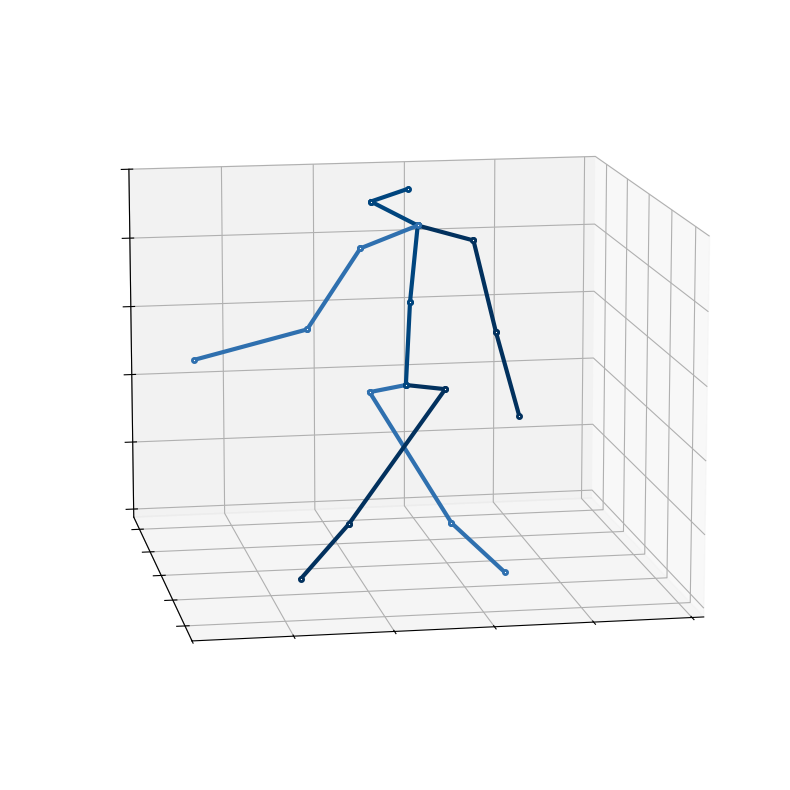

In [109]:
vlen = motion_world.shape[-1]

frames = []
joint_pairs = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6], [0, 7], [7, 8], [8, 9], [8, 11], [8, 14], [9, 10], [11, 12], [12, 13], [14, 15], [15, 16]]
joint_pairs_left = [[8, 11], [11, 12], [12, 13], [0, 4], [4, 5], [5, 6]]
joint_pairs_right = [[8, 14], [14, 15], [15, 16], [0, 1], [1, 2], [2, 3]]

color_mid = "#00457E"
color_left = "#02315E"
color_right = "#2F70AF"
for f in range(vlen):
    j3d = motion_world[:,:,f]
    print(j3d)
    fig = plt.figure(0, figsize=(10, 10))
    ax = plt.axes(projection="3d")
    ax.set_xlim(-512, 0)
    ax.set_ylim(-256, 256)
    ax.set_zlim(-512, 0)

    ax.view_init(elev=12., azim=80)
    plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
    for i in range(len(joint_pairs)):
        # if i < 8:
        #     continue
        limb = joint_pairs[i]
        xs, ys, zs = [np.array([j3d[limb[0], j], j3d[limb[1], j]]) for j in range(3)]
        if joint_pairs[i] in joint_pairs_left:
            ax.plot(-xs, -zs, -ys, color=color_left, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
        elif joint_pairs[i] in joint_pairs_right:
            ax.plot(-xs, -zs, -ys, color=color_right, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
        else:
            ax.plot(-xs, -zs, -ys, color=color_mid, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
    
    plt.show()